# **Tabular Data Science project** 
## **Notebook 1 - Observations and Experiments**

- **Team:** Amebet Belachew, Eva Hallermeier


- **Problem:**  Today, it's hard to get a nice histogram because the user doesn't know which parameter to choose to visualize his histogram for a given feature.


In fact, the number of bins in the histogram is a critical parameter that needs to be considered.

In addition, this parameter is either determined by default or left up to the user to choose, but there is no guarantee that the user will make the optimal decision for the value of this parameter. 

This can lead to histograms that are either too noisy or too simplistic to accurately represent the distribution of the data.
So we can see here that there is a problem in deciding on values of parameters for visualization of the distribution of data.





- **Goal of the project**:  We aimed to develop and validate a method for automatically selecting the number of bins (bin size) in histograms of each nemerical feature in a given dataset.

**Important**: In this research, we focused only on equal bin width and numerical features not binary.
This notebook will show and explain the research phase where we observed few features of different dataset.

**About histogram**: 

In matplotlib library, the default value for the number of bin is 10 : we will see that 10 is not all the time the best option as number of bins.

**General approach:** 

We will apply few existing methods to see if they are good and check which value seems optimal.

# Install and import the required modules and libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
import seaborn as sns
import utils

Histogram is a type of visualisation in EDA that help us understanding the distribution of the data we have.
In fact, the distribution of the data need to be similar in test and train set.

In order to check our choices, we will validate it applying it on the test dataset and we will see if the number of bin we choose give a similar histogram in the test set. 


So, we will compare histograms of train and test set by comparing the partition by bins in percentage and we will compute the average of the differences between the partitions of the two histograms (test and train set).

So, we will define a threshold value: if the average of differences between the two partitins is too high: this means that the value for bins number is not good.

# First dataset : Mobile price (small size)
https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

## Loading dataset

In [54]:
file_path = ('./data/mobile_price/train.csv')
df = pd.read_csv(file_path)

file_path_test = ('./data/mobile_price/test.csv')
df_test = pd.read_csv(file_path_test)

## Train and test set

In [55]:
utils.getDS_size(df) #train set

There are 21 columns
There are 2000 samples


In [56]:
utils.getDS_size(df_test) # test set

There are 21 columns
There are 1000 samples


In this case, train set is around 67 % of data and test set is around 33%.

So for the next dataset, we will also work on with partition 70% train and 30% test.

## Visualize train dataset

In [57]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Feature list of the dataset

In [58]:
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

All features are numericals. So  let's visualize and analyze part of them.

## Analyze the feature: Battery power

In [59]:
feature = 'battery_power'
df[feature].describe()

count    2000.000000
mean     1238.518500
std       439.418206
min       501.000000
25%       851.750000
50%      1226.000000
75%      1615.250000
max      1998.000000
Name: battery_power, dtype: float64

In [60]:
utils.getFeatureInfo(df, feature)

Feature name:  battery_power
Amplitude of values: 1560.5817939164688
Nb of different values in the feature:  1094
Range of values: 501  - 1998
Nb of samples for this feature : 2000


To solve the problem that we explained at the beginning, few methods already exists.
Matplotlib gives possibility to use them when we want a visualisation of histogram as method for nb of bins.
https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
Numpy also propose the "auto" method which is the maximum of the ‘sturges’ and ‘fd’ estimators. They say: "provides good all around performance.".


We will see here that those methods not always give good results and who really know which method to choose?
We will see also that even 'auto' method is not so good so our goal is to elaborate a method better than 'auto'.
Our idea is to apply a method that will work for all features type and distribution and size without specific information.



For each feature that we will analyze and try to apply these methods for the computation of number of bins for their histogram and we will visualize the histogram they give. We will analyze the results and critic the different methods.


Here is the list of the methods we will check in this research:

In [61]:
method_list = ['auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges','sqrt']

In [62]:
#show histograms for a given feature with all existing methods 
def show_hist_methods(df, feature):
  n=len(method_list)
  cols = 4
  rows=2

  fig, axes = plt.subplots(rows,cols,figsize=(17,5), constrained_layout=False)
  plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.0, wspace=0.2)
  fig.suptitle("Histograms of  " + feature + " with different existing methods", fontsize=18)
  fig.subplots_adjust(top=0.8)
  for i, m in  enumerate(method_list):
      r=int(i/cols)
      c=i%cols
      df[feature].hist(ax=axes[r,c], bins = m)
      nb_bins = len(np.histogram_bin_edges(df[feature], bins=m))
      axes[r,c].set_title(method_list[i] + " method with nb_bins = " + str(nb_bins))

In [63]:
# show 4 histograms with different nb of bins defined as a list
def show_hist_list(df, feature, listBin):
  n=len(listBin)
  cols = 4
  rows=1
  fig, axes = plt.subplots(rows,cols,figsize=(17,5), constrained_layout=False)
  plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.0, wspace=0.2)
  fig.suptitle("Histograms of " + feature, fontsize=18)
  fig.subplots_adjust(top=0.8)
  for i, m in  enumerate(listBin):
      df[feature].hist(ax=axes[i], bins = m)
      nb_bins = m
      axes[i].set_title("nb_bins = " + str(nb_bins))

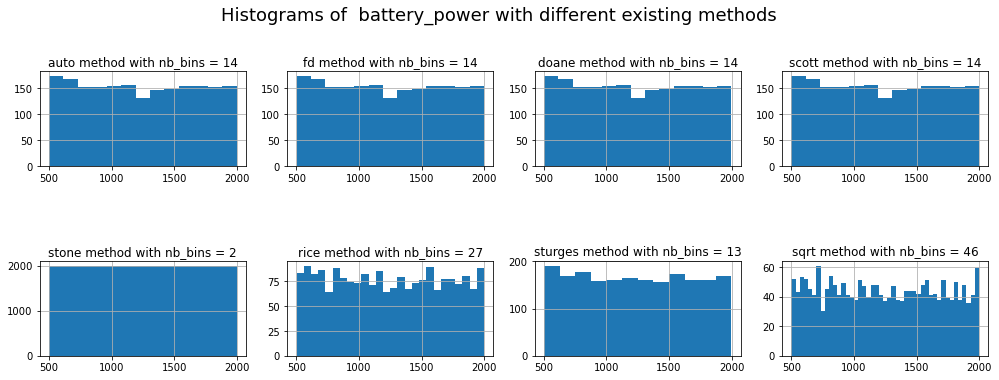

In [64]:
show_hist_methods(df, feature)


We can see that the first four methods give the same number of bin. The Stone method underestimated the number of bins: we cannot get conclusions from this. With 1094 differents values, we cannot have only 2 bins! 

Here the important information is to see that the feature have an approximative uniform distribution but not a perfect one.
For this feature, 14 seems a good choice as number of bins.
So here, it seems that choosing the 'auto' value is advised.

In [65]:
bins = 14

Let's test if this choice is also good for the test set. Test set is smaller so all bins will be smaller than the bins of the train set but the repartition need to be similar.

In [66]:
#show on a single plot histogram of test and train set.
def plot_dual_histogram(df_train, df_test, feature, bins):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Create the first histogram.
    h1 =sns.histplot(df_train, x=feature, ax=ax, kde=True, color='C0',bins = bins, alpha=0.3) 
    print(h1.get_xaxis()) 

    # Create the second histogram.
    h2= sns.histplot(df_test, x=feature, ax=ax, kde=True, color='C1',bins=bins, alpha=0.3) 
    
    ax.set_xlabel("Values")
    ax.set_ylabel("Count")
    ax.set_title(f"Train vs. Test histogram of "+ feature)

    ax.legend(["train", "test"])
    
    return [h1,h2]

In [67]:
def histogram_partition(data, num_bins, hist_range=None):
    hist, bin_edges = np.histogram(data, bins=num_bins, range=hist_range)
    return hist

XAxis(90.0,45.0)


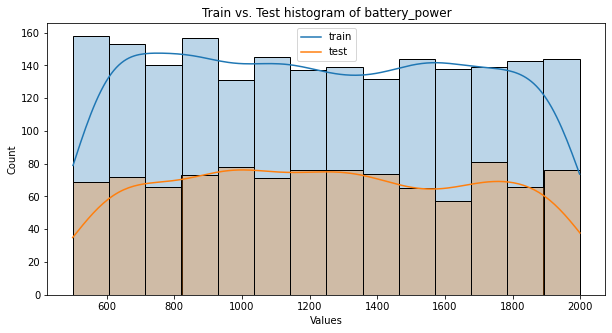

In [68]:
h1, h2 = plot_dual_histogram(df, df_test, feature, bins) # test set and train set histogram for this feature with 14 bins

In [69]:
threshold_forDifference = 0.01 # for deciding if a bin size is good : small differences between train and test set

This test will be used to evaluate our method in the test notebook. If the difference of partition between the train and test histogram is too high: the bin size choice is not good.

In [70]:
def computeDif(a, b, s):
  x = 0
  for i in range(len(a)):
    x = x + abs(a[i]-b[i])
  x = x/s
  return x

In [71]:
def showDif(df, df_test, feature, bins):
  count1 = histogram_partition(df[feature], bins) #train set
  count2 = histogram_partition(df_test[feature], bins) #test set

  #get partition
  count1 = np.true_divide(count1, count1.sum(axis=0, keepdims=True))
  count2 = np.true_divide(count2, count2.sum(axis=0, keepdims=True))

  #dif between train and test
  a = (round(computeDif(count1, count2, bins), 5))
  print(f"Difference between histograms test VS train with {bins} bins is : {a}")
  return a

In [72]:
a = showDif(df, df_test, feature, bins)

Difference between histograms test VS train with 14 bins is : 0.00714


In [73]:
check =  a < threshold_forDifference
print(check)

True


We will now apply the computation for different value of bins and this will help defining the optimal value as threshold

In [74]:
def test(df, df_test, feature):
  bins_list = range(5, 20)
  print("dif for bin size is:")
  r = []
  for b in bins_list:
    count1 = histogram_partition(df[feature], b)
    count2 = histogram_partition(df_test[feature], b)
    count1 = np.true_divide(count1, count1.sum(axis=0, keepdims=True))
    count2 = np.true_divide(count2, count2.sum(axis=0, keepdims=True))
    a = round(computeDif(count1, count2, b), 5)
    r.append(a)
    if a  < threshold_forDifference:
      print(f"value of dif {a} with {b} bins")

In [75]:
test(df, df_test, feature)

dif for bin size is:
value of dif 0.00783 with 6 bins
value of dif 0.00743 with 7 bins
value of dif 0.00889 with 9 bins
value of dif 0.00983 with 12 bins
value of dif 0.00785 with 13 bins
value of dif 0.00714 with 14 bins
value of dif 0.0078 with 15 bins
value of dif 0.00894 with 16 bins
value of dif 0.00576 with 17 bins
value of dif 0.00622 with 18 bins
value of dif 0.00747 with 19 bins


Based on this test, the optimal value seeems 17 bins but 14 give also small difference.

## Analyze on the feature: fc (Front Camera mega pixels of the mobile)

In [76]:
feature = 'fc'
df[feature].describe()

count    2000.000000
mean        4.309500
std         4.341444
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        19.000000
Name: fc, dtype: float64

In [77]:
utils.getFeatureInfo(df, feature)

Feature name:  fc
Amplitude of values: 2000.0
Nb of different values in the feature:  20
Range of values: 0  - 19
Nb of samples for this feature : 2000


We have here 20 different value so we need to have maximum 20 bins.

C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:792: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)
C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:668: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, _ = _get_bin_edges(a, bins, range, weights)


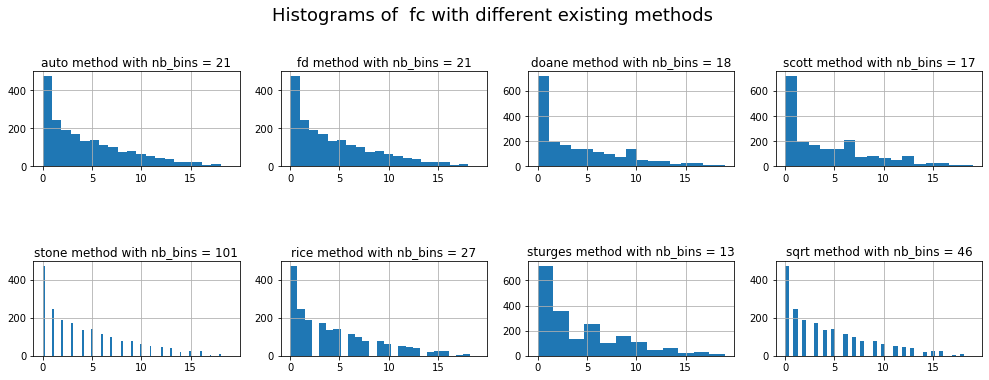

In [78]:
show_hist_methods(df, feature)

We can see  with this feature that stone and sqrt overestimated (more bins than number of different values and give very thin bins).
For this feature, value between 13 and 20 seems good.

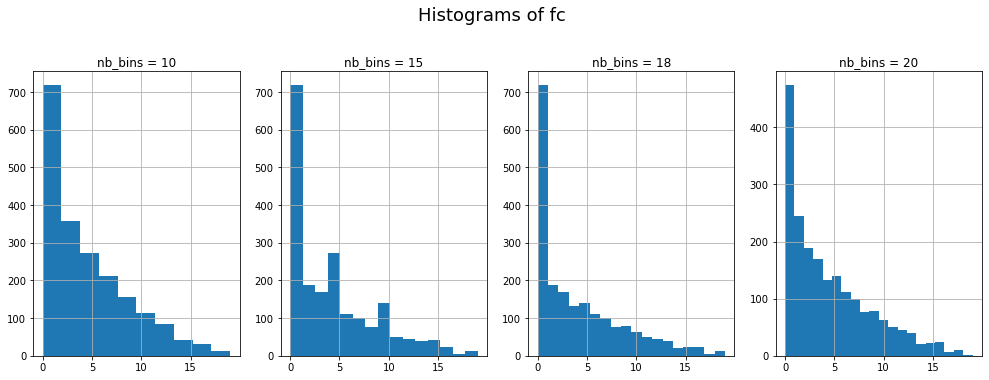

In [79]:
show_hist_list(df, feature, [10,15,18,20])

We saw in histograms above that our data is exponentially distributed.
Let's compare it to an exponential distribution with qq plot.

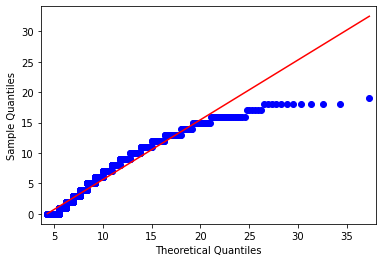

In [80]:
m=df.fc.mean()
s=df.fc.std()
p=sm.qqplot(df.fc,fit=False,dist=stats._continuous_distns.expon,loc=m, scale=s,line='r')

We see that indeed the data is exponential.
The steps/jumps we see in this plot are because that the data is discrete and not continious.

In [81]:
bins = 13
a = showDif(df, df_test, feature, bins)

Difference between histograms test VS train with 13 bins is : 0.00515


## Analyze on the feature: int_memory

Feature name:  int_memory
Amplitude of values: 1998.0
Nb of different values in the feature:  63
Range of values: 2  - 64
Nb of samples for this feature : 2000


C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:792: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)
C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:668: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, _ = _get_bin_edges(a, bins, range, weights)


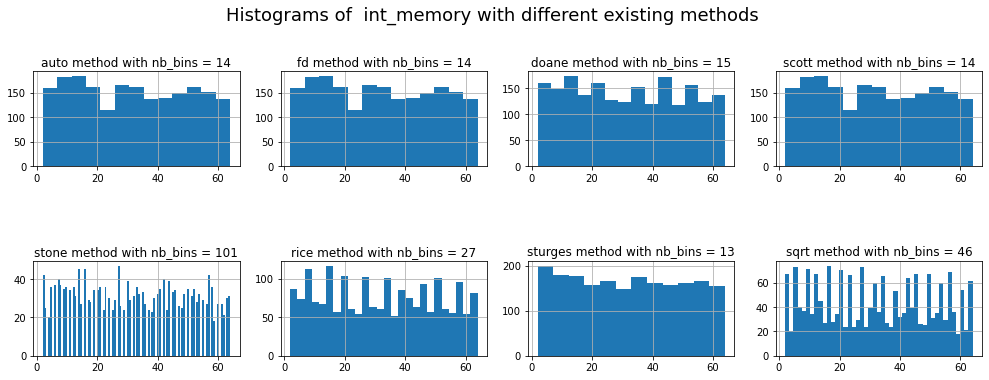

In [82]:
feature='int_memory'
df[feature].describe()
utils.getFeatureInfo(df, feature)
show_hist_methods(df, feature)

We can see here a uniform distribution
Stone and sqrt overestimate: too much bins which give too noisy plot.
Good methods here are: auto, fd, doane, sturges, scott.

In [83]:
def showPossibleHistogram(df, feature, nb_bins_list):
  cols = len(nb_bins_list)
  rows=1
  fig, axes = plt.subplots(rows,cols,figsize=(20,5), constrained_layout=False)

  fig.suptitle("Possible Histogram of " + feature, fontsize=16)
  fig.subplots_adjust(top=0.8)
  for i in  range(cols):
      n =nb_bins_list[i]
      df[feature].hist(ax=axes[i], bins = n)
      axes[i].set_title("nb_bins = " + str(n))


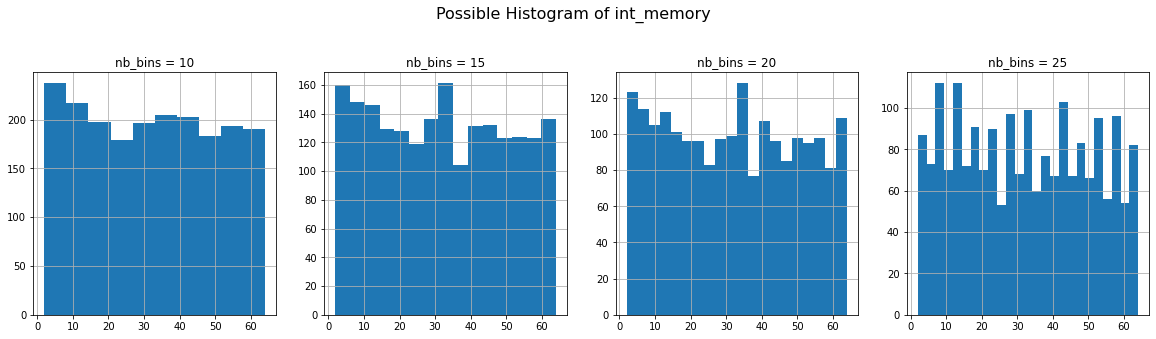

In [84]:
bins_list = [10,15,20,25]
showPossibleHistogram(df, feature, bins_list)

In [85]:
test(df, df_test, feature)

dif for bin size is:
value of dif 0.00964 with 11 bins
value of dif 0.00829 with 14 bins
value of dif 0.00887 with 15 bins
value of dif 0.00818 with 17 bins
value of dif 0.00833 with 18 bins
value of dif 0.00742 with 19 bins


In [86]:
bins = 19
a= showDif(df, df_test, feature, bins)

Difference between histograms test VS train with 19 bins is : 0.00742


## Analyze on the feature : m_dep (Mobile Depth in cm)

Feature name:  m_dep
Amplitude of values: 1999.9
Nb of different values in the feature:  10
Range of values: 0.1  - 1.0
Nb of samples for this feature : 2000


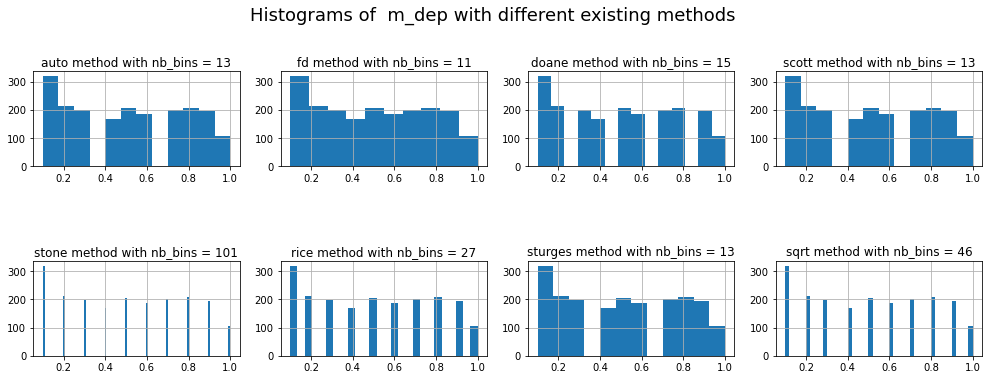

In [87]:
feature='m_dep' #between 0.1 and 1 : continious, 10 different values
df[feature].describe()
utils.getFeatureInfo(df, feature)
show_hist_methods(df, feature)

There are 10 different values and all existing methods overestimated the number of bins.
10 can be a good option.

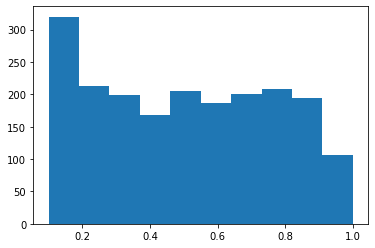

In [88]:
plt.hist(df[feature], bins=10)
plt.show()

With nb_bins =10, we can clearly see that the distribution is almost uniform but many have a small depth and high depth is less popular.

In [89]:
test(df, df_test, feature)

dif for bin size is:
value of dif 0.00978 with 9 bins
value of dif 0.0096 with 10 bins
value of dif 0.00873 with 11 bins
value of dif 0.008 with 12 bins
value of dif 0.00738 with 13 bins
value of dif 0.00686 with 14 bins
value of dif 0.0064 with 15 bins
value of dif 0.006 with 16 bins
value of dif 0.00565 with 17 bins
value of dif 0.00533 with 18 bins
value of dif 0.00505 with 19 bins


## Analyze on the feature: mobile_wt

Feature name:  mobile_wt
Amplitude of values: 1964.6003451036117
Nb of different values in the feature:  121
Range of values: 80  - 200
Nb of samples for this feature : 2000


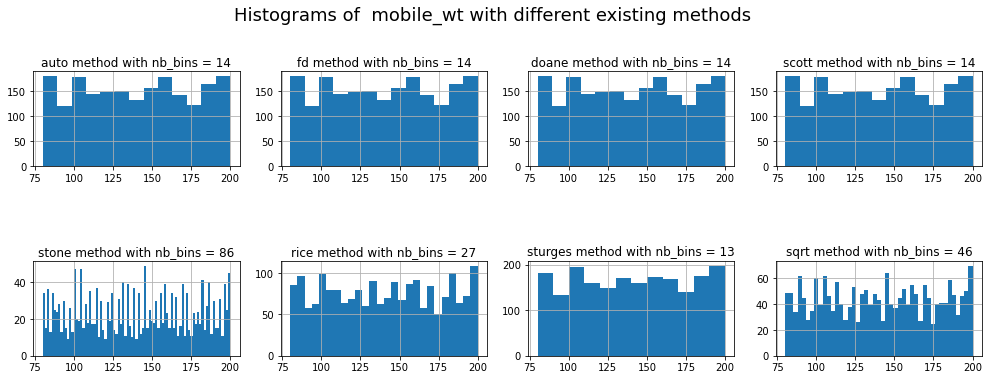

In [90]:
feature='mobile_wt' #121 diffrent values between 80 and 200
df[feature].describe()
utils.getFeatureInfo(df, feature)
show_hist_methods(df, feature)

We can see that the first four methods give the same number of bin.
For this feature, 14 (or 13) seems a good choice as nb of bins for existing method. So here, it seems that choosing the 'auto' value is advised.

# Second dataset: california houses
https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [91]:
file_path = ('./data/california_housing/california_housing_train.csv')
df = pd.read_csv(file_path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [92]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object

In [93]:
utils.getDS_size(df)

There are 9 columns
There are 17000 samples


This dataset is bigger (17 000 and the first one had 2000 samples) than the first one: so here we will be able to see if number of samples has an impact on gessing the good fit for number of bins for histogram.

## Feature: housing_median_age   


In [94]:
feature ='housing_median_age' #between 1 and 52 : discrete and around 50 different value
df[feature].describe()
utils.getFeatureInfo(df, feature)


Feature name:  housing_median_age
Amplitude of values: 16999.0
Nb of different values in the feature:  52
Range of values: 1.0  - 52.0
Nb of samples for this feature : 17000


C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:792: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)
C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:668: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, _ = _get_bin_edges(a, bins, range, weights)


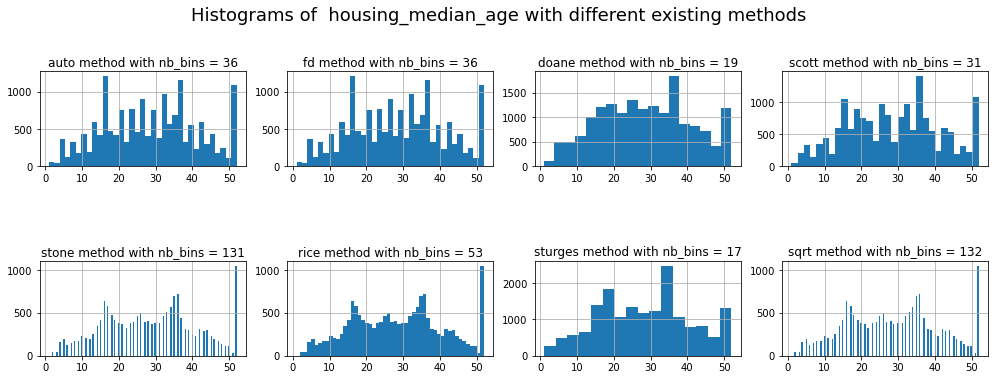

In [95]:
show_hist_methods(df, feature)

Here we have two possible good directions:
- very precise with nb_bins=nb different values (see rice method), but we don t really need too much bins.
-  more global with nb of bins between 15 and 20 (doane or sturge)

With 36 bins, we have a tooo much noisy histogram.

We saw in histograms above that our data is normally distributed. Let's compare it to normal distribution with qq plot.

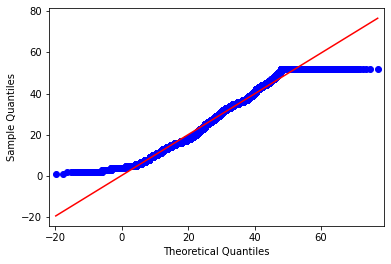

In [96]:
m=df.housing_median_age.mean()
s=df.housing_median_age.std()
p=sm.qqplot(df.housing_median_age,fit=False,dist=stats._continuous_distns.norm,loc=m, scale=s,line='r')

We see that indeed the data has a normal distribution.

## Feature: latitude

In [97]:
feature='latitude'
df[feature].describe()
utils.getFeatureInfo(df, feature)

Feature name:  latitude
Amplitude of values: 16997.862660205345
Nb of different values in the feature:  840
Range of values: 32.54  - 41.95
Nb of samples for this feature : 17000


Above we can see that there is not a big range between the values.

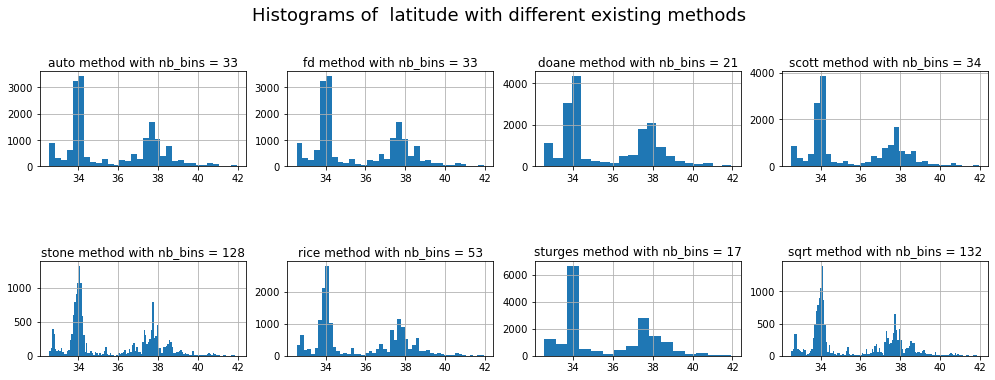

In [98]:
show_hist_methods(df,feature)

Best methods here seem: auto, fd, doane, scott, sturges.
Namely, best option of bins seems between 17 and 33.

In the histograms above we can see that the distribution has two main pic : around 34 and 38.
This is a bimodal distribution.

## Features: total_rooms, total_bedrooms
They seem to have a very similar distribution so we will try to understand what characteristic they have in common in order to hopefully get conclusions for our research.


### Feature of Total_rooms


In [100]:
feature = 'total_rooms' 
df[feature].describe()
utils.getFeatureInfo(df, feature)

Feature name:  total_rooms
Amplitude of values: 37935.0
Nb of different values in the feature:  5533
Range of values: 2.0  - 37937.0
Nb of samples for this feature : 17000


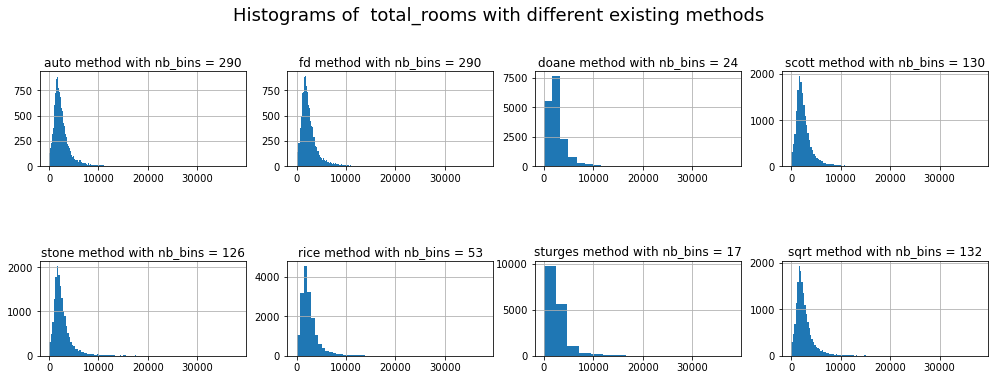

In [101]:
show_hist_methods(df, feature)

Here we have a clear log normal distribution. Here auto method has overestimate the number of bins. Here doane seems a good choice.

### Feature Total_bedrooms

In [102]:
feature='total_bedrooms' 
df[feature].describe()
utils.getFeatureInfo(df, feature)

Feature name:  total_bedrooms
Amplitude of values: 16999.0
Nb of different values in the feature:  1848
Range of values: 1.0  - 6445.0
Nb of samples for this feature : 17000


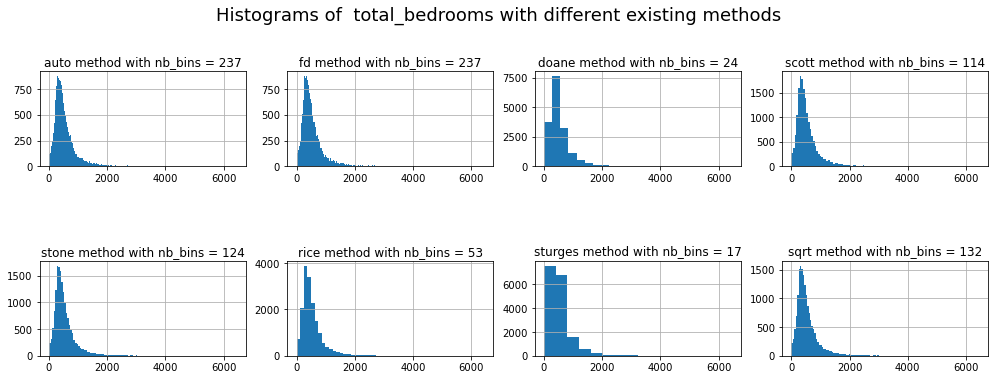

In [103]:
show_hist_methods(df, feature)

We see the same distribution like the precedent feature. Doane method seems here also a good fit.

# Other dataset : deliveries
https://www.kaggle.com/datasets/wassimchouchen/deliveries



In [107]:
p = ('./data/delivery/deliveries.csv')
df= pd.read_csv(p)
df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [108]:
utils.getDS_size(df)

There are 21 columns
There are 164750 samples


### Feature over 

Feature name:  over
Amplitude of values: 164749.0
Nb of different values in the feature:  20
Range of values: 1  - 20
Nb of samples for this feature : 164750


C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:792: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)
C:\Users\eva\anaconda3\lib\site-packages\numpy\lib\histograms.py:668: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, _ = _get_bin_edges(a, bins, range, weights)


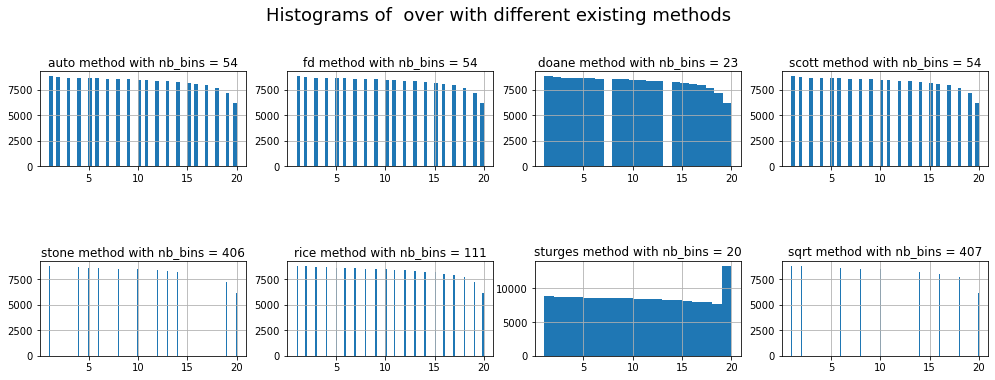

In [109]:
feature ='over'
df[feature].describe()
utils.getFeatureInfo(df, feature)
show_hist_methods(df, feature)

Sturge method seems here the best: we can clearly see a uniform distribution.
All other methods overestimated the number of bins and give histogram with many holes or thin bins. 

# Conclusion from the observations
Few methods already exists for finding the number of bins for a feature. Many times, the value returned is overestimated. In addition, some of them are more successful than others.
The Auto method gives not bad results but sometimes it overestimates the number of bins.
Also, fd, doane and sturges seems the best methods from the list we test. 
We will try to use these conclusion for building our personal method for finding the best fit for number of bins.